# PPO Trading Agent — Training & Evaluation

Train a custom PPO agent on 20 S&P 500 stocks, visualize learning curves, and evaluate on held-out test data.

In [9]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Ensure local packages are importable
sys.path.insert(0, os.path.abspath('.'))

from src.data_loader import process_data_with_indicators, split_data
from envs.naive_env import AlphaTradeEnv
from agent.ppo import PPO

## 1. Load & Process Data

In [10]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',
    'META', 'TSLA', 'NFLX', 'UNH', 'JNJ',
    'V', 'JPM', 'WMT', 'MA', 'PG',
    'HD', 'DIS', 'BAC', 'XOM', 'CVX'
]

# Load from local CSVs (already downloaded via load_data.ipynb)
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'data/{ticker}.csv', skiprows=2, index_col='Date', parse_dates=True)
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    stock_data[ticker] = df

# Add technical indicators
stock_data = process_data_with_indicators(stock_data)

# Split: train (2009-2019), val (2020), test (2021-2025)
# Your choice of split, feel free to change in src/data_loader.py
training_data, validation_data, test_data = split_data(stock_data)

## 2. Train PPO Agent

In [11]:
# Create training environment
train_env = AlphaTradeEnv(training_data)
print(f"Observation space: {train_env.observation_space.shape}")
print(f"Action space:      {train_env.action_space.shape}")
print(f"Max steps:         {train_env.max_steps}")

# Initialize PPO
ppo = PPO(
    env=train_env,
    lr=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    n_epochs=10,
    batch_size=64,
    ent_coef=0.01,
    vf_coef=0.5,
)

# Train
N_ITERATIONS = 300
STEPS_PER_ITER = 2048
training_stats = ppo.train(n_iterations=N_ITERATIONS, steps_per_iter=STEPS_PER_ITER)

Observation space: (263,)
Action space:      (20,)
Max steps:         1490
Iteration 10/300 | Mean Reward: -0.34 | Policy Loss: -0.0682 | Value Loss: 0.1595 | Entropy: 29.6772
Iteration 20/300 | Mean Reward: -0.26 | Policy Loss: -0.0641 | Value Loss: 0.2610 | Entropy: 30.6603
Iteration 30/300 | Mean Reward: -0.16 | Policy Loss: -0.0790 | Value Loss: 0.3179 | Entropy: 31.6270
Iteration 40/300 | Mean Reward: 0.02 | Policy Loss: -0.0723 | Value Loss: 0.3352 | Entropy: 32.4239
Iteration 50/300 | Mean Reward: 0.23 | Policy Loss: -0.0721 | Value Loss: 0.4605 | Entropy: 33.0684
Iteration 60/300 | Mean Reward: 0.21 | Policy Loss: -0.0628 | Value Loss: 0.5046 | Entropy: 34.0084
Iteration 70/300 | Mean Reward: 0.28 | Policy Loss: -0.0774 | Value Loss: 0.3924 | Entropy: 35.0032
Iteration 80/300 | Mean Reward: 0.18 | Policy Loss: -0.0676 | Value Loss: 0.7406 | Entropy: 35.7466
Iteration 90/300 | Mean Reward: 0.45 | Policy Loss: -0.0700 | Value Loss: 0.3606 | Entropy: 36.4774
Iteration 100/300 | Me

In [12]:
print(training_stats)

{'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

## 3. Training Curves

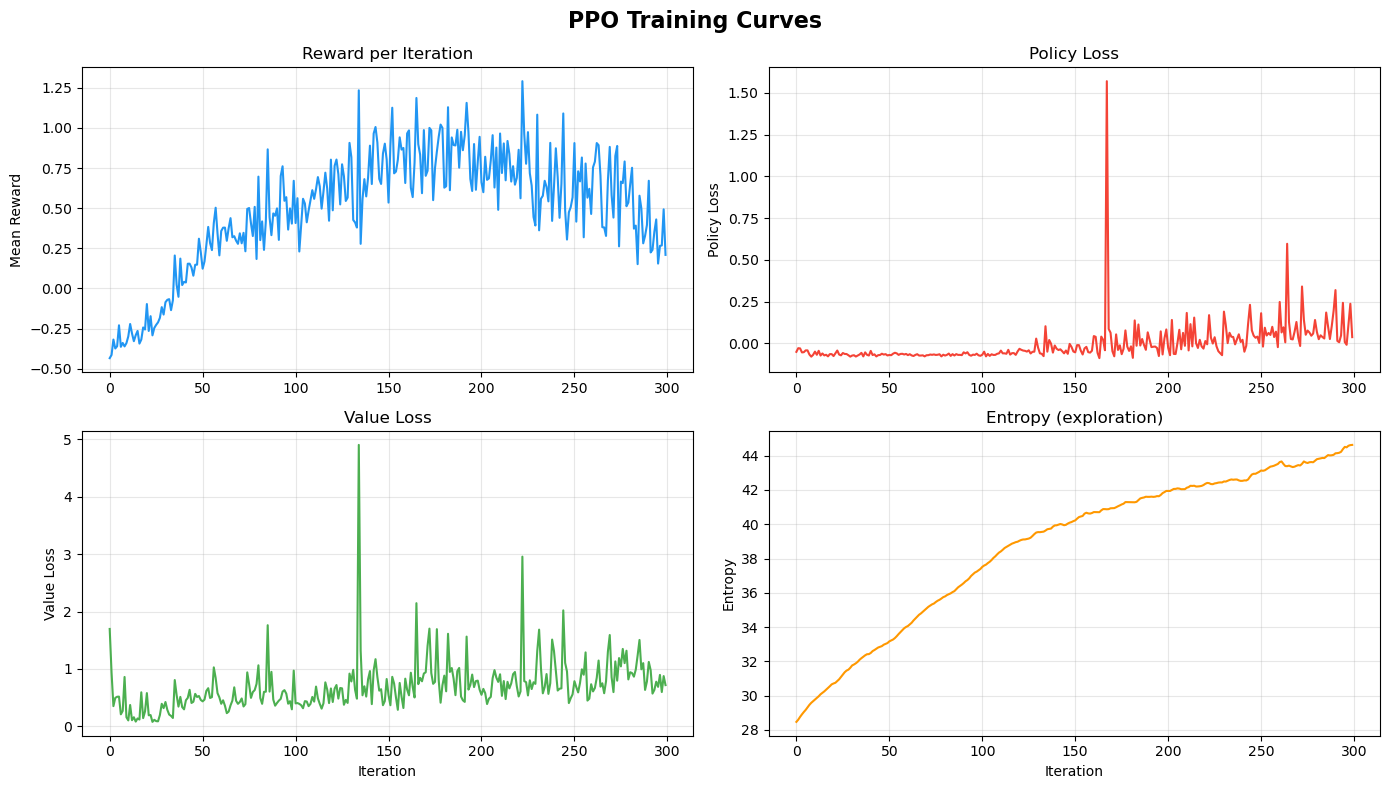

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('PPO Training Curves', fontsize=16, fontweight='bold')

iters = training_stats['iterations']

# Mean Reward
ax = axes[0, 0]
ax.plot(iters, training_stats['mean_rewards'], color='#2196F3')
ax.set_ylabel('Mean Reward')
ax.set_title('Reward per Iteration')
ax.grid(alpha=0.3)

# Policy Loss
ax = axes[0, 1]
ax.plot(iters, training_stats['policy_losses'], color='#F44336')
ax.set_ylabel('Policy Loss')
ax.set_title('Policy Loss')
ax.grid(alpha=0.3)

# Value Loss
ax = axes[1, 0]
ax.plot(iters, training_stats['value_losses'], color='#4CAF50')
ax.set_ylabel('Value Loss')
ax.set_xlabel('Iteration')
ax.set_title('Value Loss')
ax.grid(alpha=0.3)

# Entropy
ax = axes[1, 1]
ax.plot(iters, training_stats['entropies'], color='#FF9800')
ax.set_ylabel('Entropy')
ax.set_xlabel('Iteration')
ax.set_title('Entropy (exploration)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evaluate on Test Data

In [14]:
def evaluate_agent(ppo_agent, stock_data, label='Test'):
    """Run PPO on an environment and track net worth over time."""
    env = AlphaTradeEnv(stock_data)
    state, _ = env.reset()
    
    net_worths = [env.initial_balance]
    balances = [env.balance]
    steps = [0]
    
    for step in range(env.max_steps):
        action = ppo_agent.predict(state)
        state, reward, done, truncated, _ = env.step(action)
        
        net_worths.append(env.net_worth)
        balances.append(env.balance)
        steps.append(step + 1)
        
        if done or truncated:
            break
    
    # Get dates from one of the tickers
    sample_ticker = list(stock_data.keys())[0]
    dates = stock_data[sample_ticker].index[:len(net_worths)]
    
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0] * 100
    returns = np.diff(net_worths) / np.array(net_worths[:-1])
    sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
    
    peak = np.maximum.accumulate(net_worths)
    max_dd = np.max((peak - net_worths) / peak) * 100
    
    print(f"\n{'='*50}")
    print(f"{label} Results ({len(net_worths)-1} steps)")
    print(f"{'='*50}")
    print(f"Final Net Worth:  ${net_worths[-1]:,.2f}")
    print(f"Total Return:     {total_return:+.2f}%")
    print(f"Sharpe Ratio:     {sharpe:.3f}")
    print(f"Max Drawdown:     {max_dd:.2f}%")
    
    return {'net_worths': net_worths, 'dates': dates, 'returns': returns,
            'total_return': total_return, 'sharpe': sharpe, 'max_dd': max_dd}

# Evaluate on validation and test sets
val_results = evaluate_agent(ppo, validation_data, label='Validation')
test_results = evaluate_agent(ppo, test_data, label='Test')


Validation Results (252 steps)
Final Net Worth:  $318,081.49
Total Return:     +218.08%
Sharpe Ratio:     1.883
Max Drawdown:     59.42%

Test Results (1004 steps)
Final Net Worth:  $286,810.60
Total Return:     +186.81%
Sharpe Ratio:     0.837
Max Drawdown:     58.70%


## 5. Net Worth Over Time

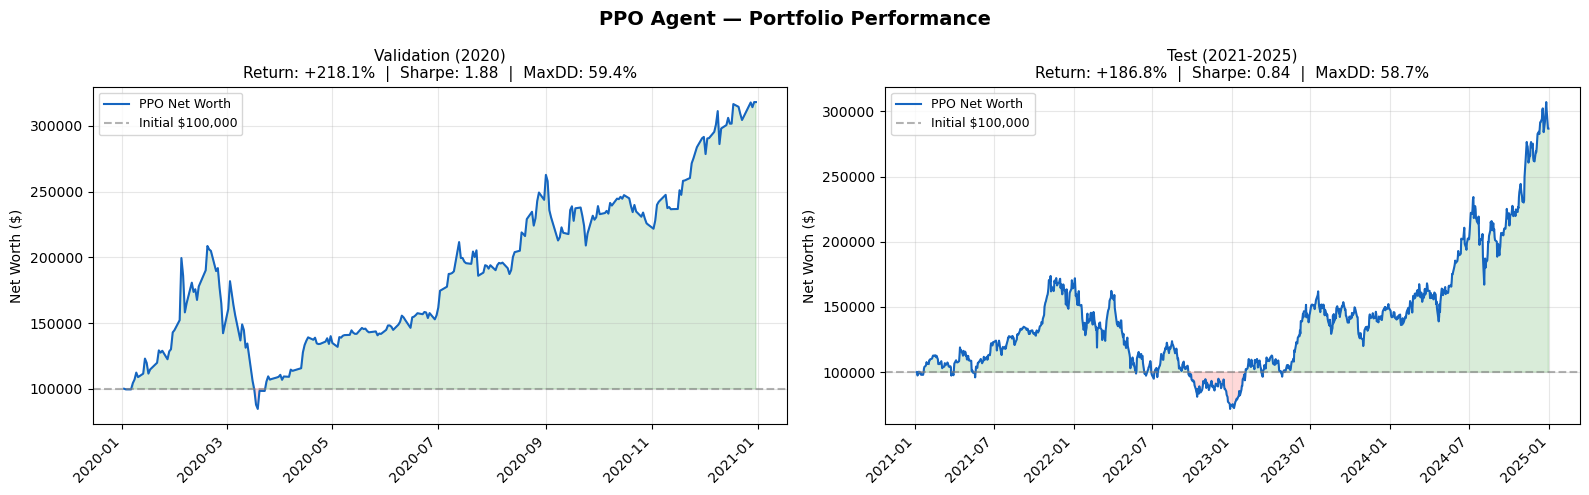

In [15]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
initial = 100000

for ax, res, title in [(axes[0], val_results, 'Validation (2020)'),
                        (axes[1], test_results, 'Test (2021-2025)')]:
    dates = res['dates']
    nw = np.array(res['net_worths'][:len(dates)])
    
    ax.plot(dates, nw, color='#1565C0', linewidth=1.5, label='PPO Net Worth')
    ax.axhline(initial, color='gray', linestyle='--', alpha=0.6, label=f'Initial ${initial:,}')
    ax.fill_between(dates, initial, nw, where=nw >= initial, alpha=0.15, color='green')
    ax.fill_between(dates, initial, nw, where=nw < initial, alpha=0.15, color='red')
    
    ax.set_title(f'{title}\nReturn: {res["total_return"]:+.1f}%  |  Sharpe: {res["sharpe"]:.2f}  |  MaxDD: {res["max_dd"]:.1f}%',
                 fontsize=11)
    ax.set_ylabel('Net Worth ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('PPO Agent — Portfolio Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Save Model

In [16]:
os.makedirs('models', exist_ok=True)

save_path = 'models/ppo_trading.pt'
torch.save({
    'policy_state_dict': ppo.policy.state_dict(),
    'optimizer_state_dict': ppo.optimizer.state_dict(),
    'training_stats': training_stats,
    'obs_shape': train_env.observation_space.shape[0],
    'action_shape': train_env.action_space.shape[0],
}, save_path)